In [1]:
import sys, os
CURRENT_TEST_DIR = os.getcwd()
sys.path.append(CURRENT_TEST_DIR + "/../../../slayerPytorch/src")

In [2]:
import slayerSNN as snn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dtw import dtw, accelerated_dtw
from numpy.linalg import norm
from joblib import Parallel, delayed
import torch
import copy
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

np.random.seed(1)
torch.manual_seed(1)

In [3]:
X = torch.load('../BioTac_Icub_data/ICUB_all.pt').numpy()
X = X.reshape([1000, 60, 75])
Y = np.load('../BioTac_Icub_data/ICUB_all_labels.npy')

In [4]:
X.shape, Y.shape

((1000, 60, 75), (1000,))

In [5]:
# X_ = np.zeros((X.shape[0],X.shape[1],X.shape[-1]*2))
# X_[...,::2] = X

In [6]:
# X = X_

In [7]:
X.shape, Y.shape

((1000, 60, 75), (1000,))

In [8]:
def get_ohe(_Y):
    target_class = np.zeros([_Y.shape[0], 20])
    for i in range(target_class.shape[0]):
        target_class[i, int(_Y[i])] = 1
    return target_class

In [9]:
X = X.reshape(X.shape[0], X.shape[1], 1, 1, X.shape[-1])
# Y = Y.reshape(Y.shape[0], Y.shape[1], 1, 1, Y.shape[-1])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42, stratify=Y)

In [11]:
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)

target_class_train = torch.FloatTensor(get_ohe(y_train).reshape(-1, 20, 1, 1, 1))
    
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)
target_class_test= torch.FloatTensor(get_ohe(y_test).reshape(-1, 20, 1, 1, 1))


X_train.shape, y_train.shape, target_class_train.shape

(torch.Size([700, 60, 1, 1, 75]),
 torch.Size([700]),
 torch.Size([700, 20, 1, 1, 1]))

In [12]:
params = {
    "neuron": {
        "type": "SRMALPHA",
        "theta": 5, # 10, 5(best)
        "tauSr": 10.0,
        "tauRef": 2.0,
        "scaleRef": 2,
        "tauRho": 1,
        "scaleRho": 1,
    },
    "simulation": {"Ts": 1.0, "tSample": 150, "nSample": 1},
    "training": {
        "error": {
            "type": "NumSpikes",  # "NumSpikes" or "ProbSpikes"
            "probSlidingWin": 20,  # only valid for ProbSpikes
            "tgtSpikeRegion": {  # valid for NumSpikes and ProbSpikes
                "start": 0,
                "stop": 150,
            },
            "tgtSpikeCount": {True: 125, False: 20},
        }
    },
}


In [13]:
train_dataset = torch.utils.data.TensorDataset(X_train, target_class_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=8)

test_dataset = torch.utils.data.TensorDataset(X_test, target_class_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset,shuffle=True,batch_size=8)

In [14]:
class SlayerMLP(torch.nn.Module):
    def __init__(self, params, input_size, hidden_size1,hidden_size2, output_size):
        super(SlayerMLP, self).__init__()
        self.output_size = output_size
        self.slayer = snn.layer(params["neuron"], params["simulation"])
        self.fc1 = self.slayer.dense(60, hidden_size1)
        self.fc2 = self.slayer.dense(hidden_size1, hidden_size2)
        self.fc3 = self.slayer.dense(hidden_size2, output_size)

    def get_spike(self, inp):
        return self.slayer.spike(inp)
    def forward(self, spike_input):
        spike_1 = self.slayer.spike(self.slayer.psp(self.fc1(spike_input)))
        spike_2 = self.slayer.spike(self.slayer.psp(self.fc2(spike_1)))
        spike_output = self.slayer.spike(self.slayer.psp(self.fc3(spike_2)))
        return spike_output

In [15]:
# class SlayerMLP(torch.nn.Module):
#     def __init__(self, params, input_size, hidden_size, output_size):
#         super(SlayerMLP, self).__init__()
#         self.output_size = output_size
#         self.slayer = snn.layer(params["neuron"], params["simulation"])
# #         self.fc1 = self.slayer.dense((1,10,6), hidden_size)
#         self.fc = self.slayer.dense((9,5,3), output_size)
#         self.conv1 = self.slayer.conv(1, 3, 2)

#     def forward(self, spike_input):
#         spike1 = self.slayer.spike(self.conv1(spike_input))
# #         print(spike1.shape)
#         spike3 = self.slayer.spike(self.fc(self.slayer.psp(spike1)))
# #         print(spike3.shape)
# #         spike_1 = self.slayer.spike(self.fc1(spike_input))
# #         spike_output = self.slayer.spike(self.slayer.psp(self.fc2(spike_1)))
#         return spike3

In [16]:
device = torch.device("cuda:0")
net = SlayerMLP(params, 19, 50, 50, 20).to(device)

In [17]:
error = snn.loss(params).to(device)
optimizer = torch.optim.RMSprop(net.parameters(), lr=0.001, weight_decay=0.5)

In [18]:
148/len(train_dataset)

0.21142857142857144

In [19]:
train_losses=[]
train_accs = []
test_losses = []
test_accs = []
for epoch in range(20001):
    net.train()
    correct = 0
    num_samples = 0
    loss_train = 0
    for i, (tact, target, label) in enumerate(train_loader):
        
        tact = tact.to(device)
        target = target.to(device)
        #print(tact.shape)
        #tact = tact.permute(0, 3, 1, 2, 4)
#         print(tact.shape)
        tact = net.get_spike(tact)
        tact_new = torch.zeros((tact.shape[0],tact.shape[1],1,1,tact.shape[-1]*2)).to(device)
        tact_new[...,::2]  = tact
        
        output = net.forward(tact_new)
        correct += torch.sum(snn.predict.getClass(output) == label).data.item()
        num_samples += len(label)
        loss = error.numSpikes(output, target)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
    if epoch%10 == 0:
        print('Epoch: ', epoch, ' --------------------------')
        print('Train loss:', loss_train/len(train_dataset))
        print('Train accuracy:', correct/len(train_dataset))
    train_accs.append(correct/len(train_dataset))
    train_losses.append(loss_train/len(train_dataset))
        
    net.eval()
    correct = 0
    num_samples = 0
    loss_test = 0
    with torch.no_grad():
        for i, (tact, target, label) in enumerate(test_loader):

            tact = tact.to(device)
            #tact = tact.permute(0, 3, 1, 2, 4)
            target = target.to(device)
            tact = net.get_spike(tact)
            tact_new = torch.zeros((tact.shape[0],tact.shape[1],1,1,tact.shape[-1]*2)).to(device)
            tact_new[...,::2]  = tact
        
            output = net.forward(tact_new)
            correct += torch.sum(snn.predict.getClass(output) == label).data.item()
            num_samples += len(label)
            loss = error.numSpikes(output, target)
            loss_test += loss.item()
            
    if epoch%10 == 0:
        print('Test loss:', loss_test/len(test_dataset))
        print('Test accuracy:', correct/len(test_dataset))
    test_accs.append(correct/len(test_dataset))
    test_losses.append(loss_test/len(test_dataset))

Epoch:  0  --------------------------
Train loss: 55.964625309535435
Train accuracy: 0.07285714285714286
Test loss: 49.404400939941404
Test accuracy: 0.12666666666666668
Epoch:  10  --------------------------
Train loss: 28.277718952723912
Train accuracy: 0.58
Test loss: 28.73793347676595
Test accuracy: 0.6033333333333334
Epoch:  20  --------------------------
Train loss: 22.510399992806573
Train accuracy: 0.7285714285714285
Test loss: 23.988877716064454
Test accuracy: 0.6733333333333333
Epoch:  30  --------------------------
Train loss: 19.335552313668387
Train accuracy: 0.75
Test loss: 21.36278902689616
Test accuracy: 0.7033333333333334
Epoch:  40  --------------------------
Train loss: 17.547895311628068
Train accuracy: 0.7828571428571428
Test loss: 19.872877718607583
Test accuracy: 0.7
Epoch:  50  --------------------------
Train loss: 16.25632377079555
Train accuracy: 0.8
Test loss: 18.798322092692057
Test accuracy: 0.73
Epoch:  60  --------------------------
Train loss: 15.292947

Epoch:  510  --------------------------
Train loss: 7.1223857239314485
Train accuracy: 0.9114285714285715
Test loss: 10.882566579182942
Test accuracy: 0.85
Epoch:  520  --------------------------
Train loss: 7.079233293533325
Train accuracy: 0.9114285714285715
Test loss: 11.187655321757
Test accuracy: 0.8433333333333334
Epoch:  530  --------------------------
Train loss: 7.024404719216483
Train accuracy: 0.9171428571428571
Test loss: 11.091722202301025
Test accuracy: 0.85
Epoch:  540  --------------------------
Train loss: 6.944238064629691
Train accuracy: 0.92
Test loss: 10.970944493611654
Test accuracy: 0.84
Epoch:  550  --------------------------
Train loss: 6.922357147761754
Train accuracy: 0.9142857142857143
Test loss: 10.915933268864949
Test accuracy: 0.8433333333333334
Epoch:  560  --------------------------
Train loss: 6.925709500994001
Train accuracy: 0.9128571428571428
Test loss: 11.000188808441163
Test accuracy: 0.85
Epoch:  570  --------------------------
Train loss: 6.8846

Epoch:  1030  --------------------------
Train loss: 5.742209493773324
Train accuracy: 0.94
Test loss: 10.241999966303508
Test accuracy: 0.86
Epoch:  1040  --------------------------
Train loss: 5.705642786026001
Train accuracy: 0.9342857142857143
Test loss: 10.272788887023927
Test accuracy: 0.86
Epoch:  1050  --------------------------
Train loss: 5.675247595650809
Train accuracy: 0.9342857142857143
Test loss: 10.182633190155029
Test accuracy: 0.8633333333333333
Epoch:  1060  --------------------------
Train loss: 5.646066586630685
Train accuracy: 0.9285714285714286
Test loss: 10.234921925862631
Test accuracy: 0.8633333333333333
Epoch:  1070  --------------------------
Train loss: 5.654557138170515
Train accuracy: 0.9328571428571428
Test loss: 10.28347791671753
Test accuracy: 0.8633333333333333
Epoch:  1080  --------------------------
Train loss: 5.625995205470494
Train accuracy: 0.94
Test loss: 10.08033322652181
Test accuracy: 0.86
Epoch:  1090  --------------------------
Train loss:

Epoch:  1540  --------------------------
Train loss: 5.063738053185599
Train accuracy: 0.9357142857142857
Test loss: 10.119833285013835
Test accuracy: 0.87
Epoch:  1550  --------------------------
Train loss: 5.010471447535924
Train accuracy: 0.9428571428571428
Test loss: 10.158966852823893
Test accuracy: 0.86
Epoch:  1560  --------------------------
Train loss: 4.989776216234479
Train accuracy: 0.9357142857142857
Test loss: 10.20884448369344
Test accuracy: 0.87
Epoch:  1570  --------------------------
Train loss: 5.010509519917624
Train accuracy: 0.9314285714285714
Test loss: 10.045133228302001
Test accuracy: 0.8666666666666667
Epoch:  1580  --------------------------
Train loss: 5.0383332797459195
Train accuracy: 0.9371428571428572
Test loss: 10.161622295379638
Test accuracy: 0.8666666666666667
Epoch:  1590  --------------------------
Train loss: 4.997752275466919
Train accuracy: 0.9328571428571428
Test loss: 10.046055577596029
Test accuracy: 0.8733333333333333
Epoch:  1600  --------

Test loss: 10.053599971135457
Test accuracy: 0.8733333333333333
Epoch:  2050  --------------------------
Train loss: 4.684971440179007
Train accuracy: 0.9442857142857143
Test loss: 9.897188886006672
Test accuracy: 0.87
Epoch:  2060  --------------------------
Train loss: 4.672642827033997
Train accuracy: 0.9342857142857143
Test loss: 9.89172223409017
Test accuracy: 0.8733333333333333
Epoch:  2070  --------------------------
Train loss: 4.670785699571882
Train accuracy: 0.9428571428571428
Test loss: 9.76927765528361
Test accuracy: 0.8733333333333333
Epoch:  2080  --------------------------
Train loss: 4.609771453993661
Train accuracy: 0.9471428571428572
Test loss: 9.88362227121989
Test accuracy: 0.87
Epoch:  2090  --------------------------
Train loss: 4.622752379008702
Train accuracy: 0.9457142857142857
Test loss: 9.898222325642903
Test accuracy: 0.8733333333333333
Epoch:  2100  --------------------------
Train loss: 4.654019038336617
Train accuracy: 0.9428571428571428
Test loss: 9.921

Test loss: 9.589922231038411
Test accuracy: 0.8733333333333333
Epoch:  2550  --------------------------
Train loss: 4.424014257703509
Train accuracy: 0.9471428571428572
Test loss: 9.588677914937337
Test accuracy: 0.8733333333333333
Epoch:  2560  --------------------------
Train loss: 4.41218573978969
Train accuracy: 0.9471428571428572
Test loss: 9.694122231801352
Test accuracy: 0.87
Epoch:  2570  --------------------------
Train loss: 4.370542820521764
Train accuracy: 0.9442857142857143
Test loss: 9.60835553487142
Test accuracy: 0.8633333333333333
Epoch:  2580  --------------------------
Train loss: 4.395661848613194
Train accuracy: 0.9385714285714286
Test loss: 9.66873327255249
Test accuracy: 0.8633333333333333
Epoch:  2590  --------------------------
Train loss: 4.4046238381522045
Train accuracy: 0.94
Test loss: 9.601899890899658
Test accuracy: 0.8733333333333333
Epoch:  2600  --------------------------
Train loss: 4.379785726411002
Train accuracy: 0.9457142857142857
Test loss: 9.479

Test loss: 9.329677645365397
Test accuracy: 0.8766666666666667
Epoch:  3060  --------------------------
Train loss: 4.137942834581648
Train accuracy: 0.95
Test loss: 9.300311266581218
Test accuracy: 0.9
Epoch:  3070  --------------------------
Train loss: 4.21105715070452
Train accuracy: 0.9457142857142857
Test loss: 9.278111089070638
Test accuracy: 0.8766666666666667
Epoch:  3080  --------------------------
Train loss: 4.1325618961879185
Train accuracy: 0.9471428571428572
Test loss: 9.45355578104655
Test accuracy: 0.8766666666666667
Epoch:  3090  --------------------------
Train loss: 4.193390474319458
Train accuracy: 0.94
Test loss: 9.364633547465006
Test accuracy: 0.88
Epoch:  3100  --------------------------
Train loss: 4.163795227323259
Train accuracy: 0.9471428571428572
Test loss: 9.492755552927653
Test accuracy: 0.87
Epoch:  3110  --------------------------
Train loss: 4.081280977385385
Train accuracy: 0.9471428571428572
Test loss: 9.460422223409017
Test accuracy: 0.876666666666

Test loss: 9.287533365885416
Test accuracy: 0.88
Epoch:  3570  --------------------------
Train loss: 3.9041666425977435
Train accuracy: 0.9528571428571428
Test loss: 9.61226671218872
Test accuracy: 0.88
Epoch:  3580  --------------------------
Train loss: 3.9195523643493653
Train accuracy: 0.9442857142857143
Test loss: 9.086199947992961
Test accuracy: 0.88
Epoch:  3590  --------------------------
Train loss: 3.9384428759983607
Train accuracy: 0.9471428571428572
Test loss: 9.26569990158081
Test accuracy: 0.88
Epoch:  3600  --------------------------
Train loss: 3.9418809468405587
Train accuracy: 0.9457142857142857
Test loss: 9.159322102864584
Test accuracy: 0.8766666666666667
Epoch:  3610  --------------------------
Train loss: 3.9165428481783184
Train accuracy: 0.9442857142857143
Test loss: 9.26786657969157
Test accuracy: 0.8833333333333333
Epoch:  3620  --------------------------
Train loss: 3.8663999768665858
Train accuracy: 0.9485714285714286
Test loss: 9.184722270965576
Test accur

Epoch:  4070  --------------------------
Train loss: 3.7621333292552404
Train accuracy: 0.9514285714285714
Test loss: 8.924799785614013
Test accuracy: 0.88
Epoch:  4080  --------------------------
Train loss: 3.7403475727353777
Train accuracy: 0.9528571428571428
Test loss: 8.864233309427897
Test accuracy: 0.8866666666666667
Epoch:  4090  --------------------------
Train loss: 3.7501523549216134
Train accuracy: 0.9485714285714286
Test loss: 8.936333300272624
Test accuracy: 0.8833333333333333
Epoch:  4100  --------------------------
Train loss: 3.7242475945608957
Train accuracy: 0.9485714285714286
Test loss: 9.059133459726969
Test accuracy: 0.8833333333333333
Epoch:  4110  --------------------------
Train loss: 3.7032666328975132
Train accuracy: 0.9485714285714286
Test loss: 8.946755622227986
Test accuracy: 0.8866666666666667
Epoch:  4120  --------------------------
Train loss: 3.7454524006162373
Train accuracy: 0.9514285714285714
Test loss: 8.760788815816243
Test accuracy: 0.88
Epoch:  

Test loss: 8.829222167332967
Test accuracy: 0.8833333333333333
Epoch:  4580  --------------------------
Train loss: 3.651214276722499
Train accuracy: 0.9485714285714286
Test loss: 8.743899955749512
Test accuracy: 0.8833333333333333
Epoch:  4590  --------------------------
Train loss: 3.6337333481652396
Train accuracy: 0.9514285714285714
Test loss: 9.040333334604899
Test accuracy: 0.8833333333333333
Epoch:  4600  --------------------------
Train loss: 3.5995142555236814
Train accuracy: 0.9514285714285714
Test loss: 8.96488873799642
Test accuracy: 0.8833333333333333
Epoch:  4610  --------------------------
Train loss: 3.6440713834762573
Train accuracy: 0.9471428571428572
Test loss: 8.761299915313721
Test accuracy: 0.8833333333333333
Epoch:  4620  --------------------------
Train loss: 3.6039809002195087
Train accuracy: 0.9514285714285714
Test loss: 8.990299892425536
Test accuracy: 0.8866666666666667
Epoch:  4630  --------------------------
Train loss: 3.625038105419704
Train accuracy: 0.

Epoch:  5080  --------------------------
Train loss: 3.5356380953107562
Train accuracy: 0.9485714285714286
Test loss: 8.721933314005534
Test accuracy: 0.8866666666666667
Epoch:  5090  --------------------------
Train loss: 3.570923763683864
Train accuracy: 0.9485714285714286
Test loss: 8.774655405680338
Test accuracy: 0.8833333333333333
Epoch:  5100  --------------------------
Train loss: 3.5987094681603566
Train accuracy: 0.9485714285714286
Test loss: 8.742366580963134
Test accuracy: 0.8866666666666667
Epoch:  5110  --------------------------
Train loss: 3.5433000019618444
Train accuracy: 0.9557142857142857
Test loss: 8.64688896814982
Test accuracy: 0.8866666666666667
Epoch:  5120  --------------------------
Train loss: 3.553933330944606
Train accuracy: 0.9471428571428572
Test loss: 8.590377833048503
Test accuracy: 0.89
Epoch:  5130  --------------------------
Train loss: 3.520666605404445
Train accuracy: 0.95
Test loss: 8.578111057281495
Test accuracy: 0.8866666666666667
Epoch:  5140

Test loss: 8.481011091868083
Test accuracy: 0.89
Epoch:  5590  --------------------------
Train loss: 3.5107142700467793
Train accuracy: 0.9485714285714286
Test loss: 8.45432217915853
Test accuracy: 0.8866666666666667
Epoch:  5600  --------------------------
Train loss: 3.4991618531090873
Train accuracy: 0.9528571428571428
Test loss: 8.431755555470785
Test accuracy: 0.89
Epoch:  5610  --------------------------
Train loss: 3.507204793521336
Train accuracy: 0.95
Test loss: 8.497922210693359
Test accuracy: 0.8866666666666667
Epoch:  5620  --------------------------
Train loss: 3.4995143270492552
Train accuracy: 0.9528571428571428
Test loss: 8.47729975382487
Test accuracy: 0.8866666666666667
Epoch:  5630  --------------------------
Train loss: 3.4628809247698102
Train accuracy: 0.9528571428571428
Test loss: 8.505977840423585
Test accuracy: 0.89
Epoch:  5640  --------------------------
Train loss: 3.502619032178606
Train accuracy: 0.9485714285714286
Test loss: 8.518833395640055
Test accura

Test loss: 8.414533228874207
Test accuracy: 0.8933333333333333
Epoch:  6110  --------------------------
Train loss: 3.429157072475978
Train accuracy: 0.9485714285714286
Test loss: 8.29289997736613
Test accuracy: 0.8866666666666667
Epoch:  6120  --------------------------
Train loss: 3.4134523330416
Train accuracy: 0.9514285714285714
Test loss: 8.31717776298523
Test accuracy: 0.89
Epoch:  6130  --------------------------
Train loss: 3.4369856548309325
Train accuracy: 0.9471428571428572
Test loss: 8.305711040496826
Test accuracy: 0.8866666666666667
Epoch:  6140  --------------------------
Train loss: 3.4288142633438112
Train accuracy: 0.9485714285714286
Test loss: 8.479844347635906
Test accuracy: 0.89
Epoch:  6150  --------------------------
Train loss: 3.446771387372698
Train accuracy: 0.9471428571428572
Test loss: 8.419588934580485
Test accuracy: 0.89
Epoch:  6160  --------------------------
Train loss: 3.4207618318285262
Train accuracy: 0.95
Test loss: 8.507277736663818
Test accuracy:

Test loss: 8.247010927200318
Test accuracy: 0.89
Epoch:  6620  --------------------------
Train loss: 3.3749951553344726
Train accuracy: 0.9528571428571428
Test loss: 8.299111080169677
Test accuracy: 0.8933333333333333
Epoch:  6630  --------------------------
Train loss: 3.326014258180346
Train accuracy: 0.9485714285714286
Test loss: 8.328455486297607
Test accuracy: 0.89
Epoch:  6640  --------------------------
Train loss: 3.3099142381123134
Train accuracy: 0.9557142857142857
Test loss: 8.28675547917684
Test accuracy: 0.8833333333333333
Epoch:  6650  --------------------------
Train loss: 3.3178523506437028
Train accuracy: 0.9585714285714285
Test loss: 8.280777695973715
Test accuracy: 0.9
Epoch:  6660  --------------------------
Train loss: 3.3889571149008613
Train accuracy: 0.95
Test loss: 8.287711194356282
Test accuracy: 0.8866666666666667
Epoch:  6670  --------------------------
Train loss: 3.360828535216195
Train accuracy: 0.95
Test loss: 8.350366675059
Test accuracy: 0.89
Epoch:  

Epoch:  7130  --------------------------
Train loss: 3.305666629246303
Train accuracy: 0.9428571428571428
Test loss: 8.39088872273763
Test accuracy: 0.8933333333333333
Epoch:  7140  --------------------------
Train loss: 3.311300007615771
Train accuracy: 0.95
Test loss: 8.261411135991414
Test accuracy: 0.8933333333333333
Epoch:  7150  --------------------------
Train loss: 3.2694476079940795
Train accuracy: 0.9542857142857143
Test loss: 8.20099977493286
Test accuracy: 0.91
Epoch:  7160  --------------------------
Train loss: 3.343280940055847
Train accuracy: 0.9528571428571428
Test loss: 8.355100024541219
Test accuracy: 0.8833333333333333
Epoch:  7170  --------------------------
Train loss: 3.286071357727051
Train accuracy: 0.95
Test loss: 8.334600048065186
Test accuracy: 0.89
Epoch:  7180  --------------------------
Train loss: 3.2965952478136336
Train accuracy: 0.9542857142857143
Test loss: 8.25763339360555
Test accuracy: 0.8966666666666666
Epoch:  7190  --------------------------
Tr

Test loss: 8.479199844996135
Test accuracy: 0.89
Epoch:  7650  --------------------------
Train loss: 3.2550951875959124
Train accuracy: 0.9514285714285714
Test loss: 8.275811208089193
Test accuracy: 0.89
Epoch:  7660  --------------------------
Train loss: 3.284104755946568
Train accuracy: 0.9528571428571428
Test loss: 8.372933228810629
Test accuracy: 0.8833333333333333
Epoch:  7670  --------------------------
Train loss: 3.2586618982042586
Train accuracy: 0.9528571428571428
Test loss: 8.370311183929443
Test accuracy: 0.9066666666666666
Epoch:  7680  --------------------------
Train loss: 3.2932142400741578
Train accuracy: 0.9471428571428572
Test loss: 8.415055548350017
Test accuracy: 0.8866666666666667
Epoch:  7690  --------------------------
Train loss: 3.2700047418049403
Train accuracy: 0.95
Test loss: 8.301999934514363
Test accuracy: 0.8866666666666667
Epoch:  7700  --------------------------
Train loss: 3.244619073186602
Train accuracy: 0.9485714285714286
Test loss: 8.35683312733

Epoch:  8150  --------------------------
Train loss: 3.206152379172189
Train accuracy: 0.9542857142857143
Test loss: 8.298688945770264
Test accuracy: 0.89
Epoch:  8160  --------------------------
Train loss: 3.2089380700247627
Train accuracy: 0.95
Test loss: 8.35238899230957
Test accuracy: 0.8933333333333333
Epoch:  8170  --------------------------
Train loss: 3.2055285603659494
Train accuracy: 0.95
Test loss: 8.228033250172933
Test accuracy: 0.8866666666666667
Epoch:  8180  --------------------------
Train loss: 3.205485681806292
Train accuracy: 0.9514285714285714
Test loss: 8.418277645111084
Test accuracy: 0.88
Epoch:  8190  --------------------------
Train loss: 3.1941761302948
Train accuracy: 0.9542857142857143
Test loss: 8.31489982922872
Test accuracy: 0.8933333333333333
Epoch:  8200  --------------------------
Train loss: 3.2386094794954574
Train accuracy: 0.9514285714285714
Test loss: 8.36906670888265
Test accuracy: 0.8866666666666667
Epoch:  8210  --------------------------
Tra

Test loss: 8.292377738952636
Test accuracy: 0.8866666666666667
Epoch:  8660  --------------------------
Train loss: 3.1750761679240633
Train accuracy: 0.9528571428571428
Test loss: 8.07298900604248
Test accuracy: 0.8966666666666666
Epoch:  8670  --------------------------
Train loss: 3.172357107571193
Train accuracy: 0.9485714285714286
Test loss: 8.220211060841878
Test accuracy: 0.89
Epoch:  8680  --------------------------
Train loss: 3.1532857050214496
Train accuracy: 0.9528571428571428
Test loss: 8.30273333231608
Test accuracy: 0.8933333333333333
Epoch:  8690  --------------------------
Train loss: 3.1789951842171806
Train accuracy: 0.9557142857142857
Test loss: 8.139355535507201
Test accuracy: 0.9133333333333333
Epoch:  8700  --------------------------
Train loss: 3.179309522083827
Train accuracy: 0.9485714285714286
Test loss: 8.238644288380941
Test accuracy: 0.8933333333333333
Epoch:  8710  --------------------------
Train loss: 3.1715285440853664
Train accuracy: 0.951428571428571

Epoch:  9160  --------------------------
Train loss: 3.1541047382354734
Train accuracy: 0.9485714285714286
Test loss: 8.16867764790853
Test accuracy: 0.8933333333333333
Epoch:  9170  --------------------------
Train loss: 3.119390447480338
Train accuracy: 0.95
Test loss: 8.299244448343913
Test accuracy: 0.89
Epoch:  9180  --------------------------
Train loss: 3.1705856697899955
Train accuracy: 0.95
Test loss: 8.190855433146158
Test accuracy: 0.8966666666666666
Epoch:  9190  --------------------------
Train loss: 3.1280380926813396
Train accuracy: 0.9485714285714286
Test loss: 8.154922103881836
Test accuracy: 0.8933333333333333
Epoch:  9200  --------------------------
Train loss: 3.094757102557591
Train accuracy: 0.9528571428571428
Test loss: 8.162155561447143
Test accuracy: 0.8933333333333333
Epoch:  9210  --------------------------
Train loss: 3.114433309010097
Train accuracy: 0.9514285714285714
Test loss: 8.18653325398763
Test accuracy: 0.8933333333333333
Epoch:  9220  -------------

Epoch:  9670  --------------------------
Train loss: 3.0791142102650233
Train accuracy: 0.9528571428571428
Test loss: 8.223288758595784
Test accuracy: 0.8933333333333333
Epoch:  9680  --------------------------
Train loss: 3.090271427971976
Train accuracy: 0.9485714285714286
Test loss: 8.263333218892415
Test accuracy: 0.89
Epoch:  9690  --------------------------
Train loss: 3.089028503554208
Train accuracy: 0.9485714285714286
Test loss: 8.274933223724366
Test accuracy: 0.89
Epoch:  9700  --------------------------
Train loss: 3.041766631943839
Train accuracy: 0.9528571428571428
Test loss: 8.225110966364543
Test accuracy: 0.8933333333333333
Epoch:  9710  --------------------------
Train loss: 3.0941094403607505
Train accuracy: 0.9542857142857143
Test loss: 8.075933361053467
Test accuracy: 0.8866666666666667
Epoch:  9720  --------------------------
Train loss: 3.0892142500196185
Train accuracy: 0.95
Test loss: 8.174022146860759
Test accuracy: 0.89
Epoch:  9730  -------------------------

Test loss: 8.27517770767212
Test accuracy: 0.89
Epoch:  10180  --------------------------
Train loss: 3.0556618469102044
Train accuracy: 0.9557142857142857
Test loss: 8.084522126515706
Test accuracy: 0.9066666666666666
Epoch:  10190  --------------------------
Train loss: 3.0648571137019567
Train accuracy: 0.95
Test loss: 8.014977652231853
Test accuracy: 0.89
Epoch:  10200  --------------------------
Train loss: 3.0551094722747805
Train accuracy: 0.9528571428571428
Test loss: 8.229433104197184
Test accuracy: 0.8933333333333333
Epoch:  10210  --------------------------
Train loss: 3.043471416745867
Train accuracy: 0.95
Test loss: 8.222266534169515
Test accuracy: 0.8933333333333333
Epoch:  10220  --------------------------
Train loss: 3.0568524193763733
Train accuracy: 0.9528571428571428
Test loss: 8.12694449742635
Test accuracy: 0.9066666666666666
Epoch:  10230  --------------------------
Train loss: 3.0119857239723205
Train accuracy: 0.9528571428571428
Test loss: 8.022388807932536
Test

Test loss: 8.04259972890218
Test accuracy: 0.8933333333333333
Epoch:  10690  --------------------------
Train loss: 3.006766651017325
Train accuracy: 0.9514285714285714
Test loss: 8.211788730621338
Test accuracy: 0.89
Epoch:  10700  --------------------------
Train loss: 2.978204778262547
Train accuracy: 0.9528571428571428
Test loss: 8.225899957021078
Test accuracy: 0.89
Epoch:  10710  --------------------------
Train loss: 3.0140857437678745
Train accuracy: 0.9542857142857143
Test loss: 8.154833262761434
Test accuracy: 0.8933333333333333
Epoch:  10720  --------------------------
Train loss: 3.0861142553601946
Train accuracy: 0.9457142857142857
Test loss: 8.06494447072347
Test accuracy: 0.89
Epoch:  10730  --------------------------
Train loss: 3.0461761120387485
Train accuracy: 0.9528571428571428
Test loss: 8.23609990119934
Test accuracy: 0.8933333333333333
Epoch:  10740  --------------------------
Train loss: 3.0089713852746147
Train accuracy: 0.9557142857142857
Test loss: 8.05519993

Epoch:  11190  --------------------------
Train loss: 3.0027476031439644
Train accuracy: 0.9514285714285714
Test loss: 8.054633337656657
Test accuracy: 0.8933333333333333
Epoch:  11200  --------------------------
Train loss: 2.983085733822414
Train accuracy: 0.9571428571428572
Test loss: 8.086677888234457
Test accuracy: 0.8933333333333333
Epoch:  11210  --------------------------
Train loss: 3.0043618849345615
Train accuracy: 0.9514285714285714
Test loss: 8.11176663716634
Test accuracy: 0.8933333333333333
Epoch:  11220  --------------------------
Train loss: 2.95015237058912
Train accuracy: 0.9542857142857143
Test loss: 8.25791106859843
Test accuracy: 0.8933333333333333
Epoch:  11230  --------------------------
Train loss: 3.0066761759349276
Train accuracy: 0.9528571428571428
Test loss: 8.260344282786052
Test accuracy: 0.8933333333333333
Epoch:  11240  --------------------------
Train loss: 2.9688952456201827
Train accuracy: 0.9528571428571428
Test loss: 8.040488780339558
Test accuracy

Epoch:  11700  --------------------------
Train loss: 2.9817856465067183
Train accuracy: 0.95
Test loss: 8.145555426279703
Test accuracy: 0.8966666666666666
Epoch:  11710  --------------------------
Train loss: 2.963457087789263
Train accuracy: 0.9528571428571428
Test loss: 8.065755513509115
Test accuracy: 0.89
Epoch:  11720  --------------------------
Train loss: 2.9712904521397183
Train accuracy: 0.9528571428571428
Test loss: 8.010322081247965
Test accuracy: 0.8966666666666666
Epoch:  11730  --------------------------
Train loss: 3.0059904629843577
Train accuracy: 0.9485714285714286
Test loss: 8.231011079947153
Test accuracy: 0.8966666666666666
Epoch:  11740  --------------------------
Train loss: 2.9686523267201017
Train accuracy: 0.9514285714285714
Test loss: 8.070355450312297
Test accuracy: 0.89
Epoch:  11750  --------------------------
Train loss: 2.9700428336007256
Train accuracy: 0.9485714285714286
Test loss: 8.088588835398356
Test accuracy: 0.8933333333333333
Epoch:  11760  --

Epoch:  12210  --------------------------
Train loss: 3.014999978882926
Train accuracy: 0.9428571428571428
Test loss: 8.252122116088866
Test accuracy: 0.8966666666666666
Epoch:  12220  --------------------------
Train loss: 2.9820809473310197
Train accuracy: 0.9528571428571428
Test loss: 8.1121555519104
Test accuracy: 0.9133333333333333
Epoch:  12230  --------------------------
Train loss: 2.9956475523539954
Train accuracy: 0.9485714285714286
Test loss: 8.15380000114441
Test accuracy: 0.89
Epoch:  12240  --------------------------
Train loss: 2.9375047070639475
Train accuracy: 0.9528571428571428
Test loss: 8.244711020787557
Test accuracy: 0.8966666666666666
Epoch:  12250  --------------------------
Train loss: 2.9795142378125874
Train accuracy: 0.95
Test loss: 8.195566631952921
Test accuracy: 0.9
Epoch:  12260  --------------------------
Train loss: 2.985376170022147
Train accuracy: 0.9471428571428572
Test loss: 8.117522083918253
Test accuracy: 0.9066666666666666
Epoch:  12270  -------

Test loss: 8.085310961405437
Test accuracy: 0.8933333333333333
Epoch:  12730  --------------------------
Train loss: 2.9131666782924106
Train accuracy: 0.9557142857142857
Test loss: 8.192277666727701
Test accuracy: 0.8933333333333333
Epoch:  12740  --------------------------
Train loss: 2.9625333452224734
Train accuracy: 0.9485714285714286
Test loss: 8.018433307011922
Test accuracy: 0.8966666666666666
Epoch:  12750  --------------------------
Train loss: 2.954642810480935
Train accuracy: 0.9514285714285714
Test loss: 8.076355555852254
Test accuracy: 0.9
Epoch:  12760  --------------------------
Train loss: 2.9410999407087055
Train accuracy: 0.9514285714285714
Test loss: 8.21325545946757
Test accuracy: 0.8966666666666666
Epoch:  12770  --------------------------
Train loss: 2.932228558404105
Train accuracy: 0.9528571428571428
Test loss: 8.019899853070577
Test accuracy: 0.8966666666666666
Epoch:  12780  --------------------------
Train loss: 2.9379618794577462
Train accuracy: 0.951428571

Test loss: 8.217822030385335
Test accuracy: 0.89
Epoch:  13230  --------------------------
Train loss: 2.968980928829738
Train accuracy: 0.9471428571428572
Test loss: 8.105544481277466
Test accuracy: 0.8966666666666666
Epoch:  13240  --------------------------
Train loss: 2.9689618464878627
Train accuracy: 0.9471428571428572
Test loss: 8.058299999237061
Test accuracy: 0.8966666666666666
Epoch:  13250  --------------------------
Train loss: 2.933700008392334
Train accuracy: 0.9528571428571428
Test loss: 8.158033275604248
Test accuracy: 0.8966666666666666
Epoch:  13260  --------------------------
Train loss: 2.901699969427926
Train accuracy: 0.9585714285714285
Test loss: 8.049455521901448
Test accuracy: 0.9
Epoch:  13270  --------------------------
Train loss: 2.9434666735785346
Train accuracy: 0.9528571428571428
Test loss: 8.05275557200114
Test accuracy: 0.9
Epoch:  13280  --------------------------
Train loss: 2.9589618403570994
Train accuracy: 0.9471428571428572
Test loss: 8.197266343

Test loss: 8.249255441029867
Test accuracy: 0.8933333333333333
Epoch:  13730  --------------------------
Train loss: 2.956471389702388
Train accuracy: 0.9514285714285714
Test loss: 8.082033166885376
Test accuracy: 0.89
Epoch:  13740  --------------------------
Train loss: 2.9392428289140975
Train accuracy: 0.9471428571428572
Test loss: 8.416711018880209
Test accuracy: 0.8933333333333333
Epoch:  13750  --------------------------
Train loss: 2.9250666400364467
Train accuracy: 0.9585714285714285
Test loss: 8.228766536712646
Test accuracy: 0.89
Epoch:  13760  --------------------------
Train loss: 2.9126999916349137
Train accuracy: 0.95
Test loss: 8.418922360738119
Test accuracy: 0.8866666666666667
Epoch:  13770  --------------------------
Train loss: 2.910590478352138
Train accuracy: 0.9528571428571428
Test loss: 8.116377623875936
Test accuracy: 0.8866666666666667
Epoch:  13780  --------------------------
Train loss: 2.938680932181222
Train accuracy: 0.9542857142857143
Test loss: 8.112988

Test loss: 8.204177560806274
Test accuracy: 0.8966666666666666
Epoch:  14230  --------------------------
Train loss: 2.9404428454807827
Train accuracy: 0.95
Test loss: 8.252377872467042
Test accuracy: 0.8933333333333333
Epoch:  14240  --------------------------
Train loss: 2.906085683277675
Train accuracy: 0.9514285714285714
Test loss: 8.377300078074137
Test accuracy: 0.8933333333333333
Epoch:  14250  --------------------------
Train loss: 2.9361095448902677
Train accuracy: 0.9471428571428572
Test loss: 8.354188874562581
Test accuracy: 0.8933333333333333
Epoch:  14260  --------------------------
Train loss: 2.9233428021839685
Train accuracy: 0.95
Test loss: 8.09782219250997
Test accuracy: 0.8933333333333333
Epoch:  14270  --------------------------
Train loss: 2.922919046878815
Train accuracy: 0.9528571428571428
Test loss: 8.846199858983358
Test accuracy: 0.88
Epoch:  14280  --------------------------
Train loss: 2.909538119861058
Train accuracy: 0.9514285714285714
Test loss: 8.2327998

Test loss: 8.167944405873616
Test accuracy: 0.89
Epoch:  14730  --------------------------
Train loss: 2.9398428521837507
Train accuracy: 0.95
Test loss: 8.149422124226888
Test accuracy: 0.89
Epoch:  14740  --------------------------
Train loss: 2.879028513772147
Train accuracy: 0.9542857142857143
Test loss: 8.208155501683553
Test accuracy: 0.8933333333333333
Epoch:  14750  --------------------------
Train loss: 2.9016856561388287
Train accuracy: 0.9457142857142857
Test loss: 8.272822300593058
Test accuracy: 0.8933333333333333
Epoch:  14760  --------------------------
Train loss: 2.9085094778878346
Train accuracy: 0.9528571428571428
Test loss: 8.207155532836914
Test accuracy: 0.89
Epoch:  14770  --------------------------
Train loss: 2.8965286135673525
Train accuracy: 0.9471428571428572
Test loss: 8.03627779642741
Test accuracy: 0.8933333333333333
Epoch:  14780  --------------------------
Train loss: 2.8933808967045374
Train accuracy: 0.9585714285714285
Test loss: 8.182455412546794
Tes

Test loss: 8.133422037760417
Test accuracy: 0.8933333333333333
Epoch:  15240  --------------------------
Train loss: 2.900090453965323
Train accuracy: 0.9528571428571428
Test loss: 8.057933349609375
Test accuracy: 0.8966666666666666
Epoch:  15250  --------------------------
Train loss: 2.917190418243408
Train accuracy: 0.9514285714285714
Test loss: 8.13738881111145
Test accuracy: 0.8966666666666666
Epoch:  15260  --------------------------
Train loss: 2.9053952431678773
Train accuracy: 0.9428571428571428
Test loss: 8.165700016021729
Test accuracy: 0.8933333333333333
Epoch:  15270  --------------------------
Train loss: 2.880509470190321
Train accuracy: 0.9514285714285714
Test loss: 8.074088929494222
Test accuracy: 0.8966666666666666
Epoch:  15280  --------------------------
Train loss: 2.8497856872422354
Train accuracy: 0.9514285714285714
Test loss: 8.124155416488648
Test accuracy: 0.8933333333333333
Epoch:  15290  --------------------------
Train loss: 2.9082333012989587
Train accurac

Test loss: 8.414622344970702
Test accuracy: 0.8966666666666666
Epoch:  15740  --------------------------
Train loss: 2.9241142868995667
Train accuracy: 0.9457142857142857
Test loss: 8.118344504038493
Test accuracy: 0.8966666666666666
Epoch:  15750  --------------------------
Train loss: 2.848180922780718
Train accuracy: 0.9542857142857143
Test loss: 8.232755273183187
Test accuracy: 0.8966666666666666
Epoch:  15760  --------------------------
Train loss: 2.8641475691114153
Train accuracy: 0.9542857142857143
Test loss: 8.08329994837443
Test accuracy: 0.8966666666666666
Epoch:  15770  --------------------------
Train loss: 2.8832475978987557
Train accuracy: 0.9557142857142857
Test loss: 8.22936666170756
Test accuracy: 0.8966666666666666
Epoch:  15780  --------------------------
Train loss: 2.880719042505537
Train accuracy: 0.9528571428571428
Test loss: 8.310911235809327
Test accuracy: 0.92
Epoch:  15790  --------------------------
Train loss: 2.889223771776472
Train accuracy: 0.9471428571

Epoch:  16240  --------------------------
Train loss: 2.86645234142031
Train accuracy: 0.9485714285714286
Test loss: 8.253222258885701
Test accuracy: 0.9
Epoch:  16250  --------------------------
Train loss: 2.903404766491481
Train accuracy: 0.9471428571428572
Test loss: 8.129433218638102
Test accuracy: 0.9
Epoch:  16260  --------------------------
Train loss: 2.838066658973694
Train accuracy: 0.95
Test loss: 8.087811120351155
Test accuracy: 0.9
Epoch:  16270  --------------------------
Train loss: 2.841690449033465
Train accuracy: 0.9585714285714285
Test loss: 8.120955530802409
Test accuracy: 0.9
Epoch:  16280  --------------------------
Train loss: 2.854328530856541
Train accuracy: 0.9542857142857143
Test loss: 8.446877695719401
Test accuracy: 0.8933333333333333
Epoch:  16290  --------------------------
Train loss: 2.8377618861198424
Train accuracy: 0.9485714285714286
Test loss: 8.096633256276448
Test accuracy: 0.9
Epoch:  16300  --------------------------
Train loss: 2.8931428132738

Epoch:  16750  --------------------------
Train loss: 2.8222714315141952
Train accuracy: 0.9585714285714285
Test loss: 8.179421981175741
Test accuracy: 0.8966666666666666
Epoch:  16760  --------------------------
Train loss: 2.8432761570385523
Train accuracy: 0.95
Test loss: 8.040811204910279
Test accuracy: 0.8966666666666666
Epoch:  16770  --------------------------
Train loss: 2.908018974576678
Train accuracy: 0.9528571428571428
Test loss: 8.02404450416565
Test accuracy: 0.8933333333333333
Epoch:  16780  --------------------------
Train loss: 2.8840475508144925
Train accuracy: 0.9457142857142857
Test loss: 8.165266609191894
Test accuracy: 0.9
Epoch:  16790  --------------------------
Train loss: 2.850047593797956
Train accuracy: 0.9471428571428572
Test loss: 8.08785540898641
Test accuracy: 0.8966666666666666
Epoch:  16800  --------------------------
Train loss: 2.8102808713912966
Train accuracy: 0.9571428571428572
Test loss: 8.141366640726725
Test accuracy: 0.8933333333333333
Epoch: 

Epoch:  17250  --------------------------
Train loss: 2.8778190108707973
Train accuracy: 0.9457142857142857
Test loss: 8.114877653121948
Test accuracy: 0.9
Epoch:  17260  --------------------------
Train loss: 2.802414264678955
Train accuracy: 0.9528571428571428
Test loss: 8.000033144950867
Test accuracy: 0.9166666666666666
Epoch:  17270  --------------------------
Train loss: 2.8002189997264315
Train accuracy: 0.9514285714285714
Test loss: 8.091522146860758
Test accuracy: 0.9033333333333333
Epoch:  17280  --------------------------
Train loss: 2.8539285520144873
Train accuracy: 0.9528571428571428
Test loss: 7.9699667040507
Test accuracy: 0.9
Epoch:  17290  --------------------------
Train loss: 2.8427476140430996
Train accuracy: 0.9514285714285714
Test loss: 7.96541109085083
Test accuracy: 0.9033333333333333
Epoch:  17300  --------------------------
Train loss: 2.796323756149837
Train accuracy: 0.9485714285714286
Test loss: 8.02902214050293
Test accuracy: 0.9
Epoch:  17310  ----------

Epoch:  17750  --------------------------
Train loss: 2.795985691547394
Train accuracy: 0.9542857142857143
Test loss: 8.057455514272053
Test accuracy: 0.8966666666666666
Epoch:  17760  --------------------------
Train loss: 2.84856662273407
Train accuracy: 0.9485714285714286
Test loss: 7.9455555788675944
Test accuracy: 0.9233333333333333
Epoch:  17770  --------------------------
Train loss: 2.842404727935791
Train accuracy: 0.95
Test loss: 7.9731666946411135
Test accuracy: 0.9
Epoch:  17780  --------------------------
Train loss: 2.809414213725499
Train accuracy: 0.9471428571428572
Test loss: 7.978099956512451
Test accuracy: 0.9033333333333333
Epoch:  17790  --------------------------
Train loss: 2.8355047297477722
Train accuracy: 0.9457142857142857
Test loss: 7.911344448725383
Test accuracy: 0.9033333333333333
Epoch:  17800  --------------------------
Train loss: 2.83723806313106
Train accuracy: 0.9542857142857143
Test loss: 8.078766848246257
Test accuracy: 0.89
Epoch:  17810  -------

Epoch:  18260  --------------------------
Train loss: 2.793157103061676
Train accuracy: 0.95
Test loss: 7.84940000851949
Test accuracy: 0.8933333333333333
Epoch:  18270  --------------------------
Train loss: 2.8127856486184255
Train accuracy: 0.9442857142857143
Test loss: 7.917677847544352
Test accuracy: 0.8966666666666666
Epoch:  18280  --------------------------
Train loss: 2.7815428117343357
Train accuracy: 0.9542857142857143
Test loss: 7.937066561381022
Test accuracy: 0.8966666666666666
Epoch:  18290  --------------------------
Train loss: 2.793285662106105
Train accuracy: 0.95
Test loss: 7.978944339752197
Test accuracy: 0.9
Epoch:  18300  --------------------------
Train loss: 2.8147857403755188
Train accuracy: 0.9514285714285714
Test loss: 7.892155469258626
Test accuracy: 0.9
Epoch:  18310  --------------------------
Train loss: 2.7833713929993764
Train accuracy: 0.9542857142857143
Test loss: 8.045844217936198
Test accuracy: 0.8966666666666666
Epoch:  18320  --------------------

Epoch:  18760  --------------------------
Train loss: 2.7669713640213014
Train accuracy: 0.9528571428571428
Test loss: 7.85051121711731
Test accuracy: 0.9
Epoch:  18770  --------------------------
Train loss: 2.766647595337459
Train accuracy: 0.9528571428571428
Test loss: 7.778388878504435
Test accuracy: 0.8966666666666666
Epoch:  18780  --------------------------
Train loss: 2.822299942629678
Train accuracy: 0.9471428571428572
Test loss: 7.922822081247966
Test accuracy: 0.8966666666666666
Epoch:  18790  --------------------------
Train loss: 2.797228538649423
Train accuracy: 0.9557142857142857
Test loss: 7.866855462392171
Test accuracy: 0.8933333333333333
Epoch:  18800  --------------------------
Train loss: 2.7588666003090996
Train accuracy: 0.95
Test loss: 8.151522137324015
Test accuracy: 0.9033333333333333
Epoch:  18810  --------------------------
Train loss: 2.7623047644751413
Train accuracy: 0.9514285714285714
Test loss: 7.840377906163534
Test accuracy: 0.8933333333333333
Epoch: 

Epoch:  19270  --------------------------
Train loss: 2.781095220361437
Train accuracy: 0.95
Test loss: 7.880833346048991
Test accuracy: 0.8966666666666666
Epoch:  19280  --------------------------
Train loss: 2.7461571529933386
Train accuracy: 0.9514285714285714
Test loss: 7.7562999947865805
Test accuracy: 0.8966666666666666
Epoch:  19290  --------------------------
Train loss: 2.774704773085458
Train accuracy: 0.9514285714285714
Test loss: 7.882988850275676
Test accuracy: 0.8933333333333333
Epoch:  19300  --------------------------
Train loss: 2.771309474876949
Train accuracy: 0.9528571428571428
Test loss: 7.799122145970663
Test accuracy: 0.9
Epoch:  19310  --------------------------
Train loss: 2.7724428360802786
Train accuracy: 0.9528571428571428
Test loss: 8.03740001042684
Test accuracy: 0.9
Epoch:  19320  --------------------------
Train loss: 2.766447606767927
Train accuracy: 0.9485714285714286
Test loss: 7.968644278844198
Test accuracy: 0.8966666666666666
Epoch:  19330  -------

Epoch:  19770  --------------------------
Train loss: 2.7589238003322056
Train accuracy: 0.95
Test loss: 7.800788911183675
Test accuracy: 0.8933333333333333
Epoch:  19780  --------------------------
Train loss: 2.7506714214597427
Train accuracy: 0.9514285714285714
Test loss: 7.919122236569723
Test accuracy: 0.9
Epoch:  19790  --------------------------
Train loss: 2.7420903955187117
Train accuracy: 0.95
Test loss: 7.822011165618896
Test accuracy: 0.8966666666666666
Epoch:  19800  --------------------------
Train loss: 2.7134904905727932
Train accuracy: 0.9471428571428572
Test loss: 7.841444466908773
Test accuracy: 0.9
Epoch:  19810  --------------------------
Train loss: 2.7863713802610124
Train accuracy: 0.95
Test loss: 7.985044275919597
Test accuracy: 0.8933333333333333
Epoch:  19820  --------------------------
Train loss: 2.7755142498016356
Train accuracy: 0.9485714285714286
Test loss: 7.835133339564005
Test accuracy: 0.8933333333333333
Epoch:  19830  --------------------------
Trai

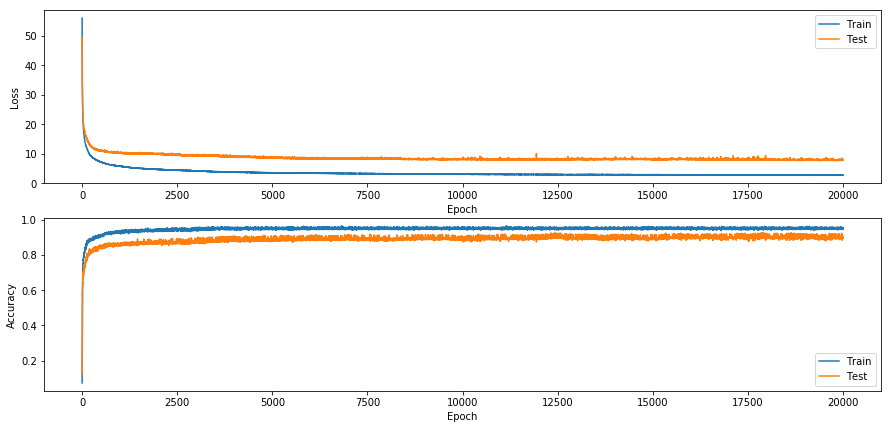

In [20]:
fig, ax = plt.subplots(2, figsize=(15,7))

ax[0].plot(train_losses)
ax[0].plot(test_losses)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(['Train', 'Test'])

ax[1].plot(train_accs)
ax[1].plot(test_accs)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend(['Train', 'Test'])

plt.show()

In [21]:
np.max(test_accs)

0.9266666666666666

In [22]:
np.max(train_accs)

0.9657142857142857